In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import spacy
import gutenberg.acquire
import gutenberg.cleanup
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import pickle
import os

def read_or_pickle(path, load_default):
    path += '.pickle'
    if os.path.isfile(path):
        return pickle.load(open(path, 'rb'))
    else:
        data = load_default()
        pickle.dump(data, open(path, 'wb'))
        return data

def load_book(id):
    return gutenberg.cleanup.strip_headers(gutenberg.acquire.load_etext(id)).strip()

In [3]:
class CharRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model, n_layers):
        super().__init__()


        self.encoder = nn.Embedding(input_size, hidden_size)
        if model == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        else:
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size) 

    def forward(self, inp, hidden):
        batch_size = inp.size(0)
        encoded = self.encoder(inp)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

In [4]:
def char_tensor(chars, vocab):
    tensor = torch.zeros(len(chars), dtype=torch.long, device=device)
    for i, char in enumerate(chars):
        tensor[i] = vocab.index(char)
    return tensor 

def random_training_set(doc, vocab, chunk_len, batch_size):
    inp = torch.zeros(batch_size, chunk_len, dtype=torch.long, device=device)
    target = inp.clone()
    file_len = len(doc)

    for i in range(batch_size):
        start_index = random.randrange(file_len - (chunk_len + 1))
        end_index = start_index + chunk_len + 1
        chunk = doc[start_index:end_index]
        inp[i] = char_tensor(chunk[:-1], vocab)
        target[i] = char_tensor(chunk[1:], vocab)

    return inp, target

In [5]:
def train(vocab, inp, target, net, criterion, optimizer, teacher_ratio):
    batch_size = inp.size(0)
    hidden = None
    net.zero_grad()
    loss = 0

    for i in range(inp.size(1)):
      if i == 0 or random.random() > teacher_ratio:
        actual_inp = inp[:,i]
      else:
        actual_inp = torch.zeros(batch_size, 1, dtype=torch.long, device=device)
        for bi, max_i in enumerate(last_output.argmax(1)):
          actual_inp[bi] = max_i
      output, hidden = net(actual_inp, hidden)
      output = output.view(batch_size, -1)
      last_output = output
      loss += criterion(output.view(batch_size, -1), target[:,i])

    loss.backward()
    optimizer.step()

    return loss.item() / inp.size(1)

In [6]:
def run_train(doc, vocab, net, criterion, optimizer, n_epochs, chunk_len, batch_size, teacher_ratio, plot_every=1):
    losses = []

    for epoch in tqdm(range(n_epochs)):
        inp, target = random_training_set(doc, vocab, chunk_len, batch_size)
        loss = train(vocab, inp, target, net, criterion, optimizer, teacher_ratio)

        if DEBUG:
            return

        if LIVE_PLOT:
            liveloss.update({'loss': loss / plot_every})
            liveloss.draw()

        losses.append(loss / plot_every)

    plt.figure()
    plt.plot(losses)
    
    print(f'Final loss: {losses[-1]}')

In [2]:
doc = load_book(84)
vocab = list(set(doc))

NameError: name 'load_book' is not defined

In [16]:
DEBUG = False
LIVE_PLOT = False
liveloss = PlotLosses()
hidden_size = 100
n_layers = 2
model = 'gru'
learning_rate = 0.01
n_epochs = 100
chunk_len = 200
batch_size = 64
teacher_ratio = 0.8

net = CharRNN(len(vocab), hidden_size, len(vocab), model, n_layers, teacher_ratio).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


100%|██████████| 100/100 [01:57<00:00,  1.16s/it]


Final loss: 2.9384515380859373


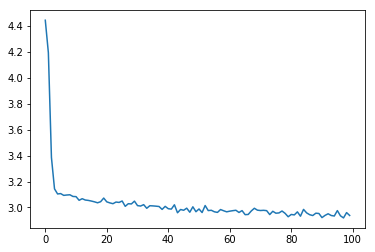

In [17]:

run_train(doc, vocab, net, criterion, optimizer, n_epochs, chunk_len, batch_size)
torch.save(net.state_dict(), 'state.pt')

In [19]:

net.load_state_dict(torch.load('state.pt'))
def sample(vocab, net, prime_str, predict_len, temperature, beam_number):
    with torch.no_grad():
        prime_str = list(prime_str)
        predicted = list(prime_str)

        hidden = None
        prime_inp = char_tensor(prime_str, vocab).unsqueeze(0)
        for i in range(len(prime_str)):
            _, hidden = net(prime_inp[:,i], hidden)

        beams = [(hidden, prime_str)]

        for i in range(predict_len):
            output_pairs = []
            new_hidden = []
            for beami, (hidden, result) in enumerate(beams):
                inp = char_tensor(result[-1], vocab).unsqueeze(0)
                output, hidden = net(inp, hidden)
                output_dist = output.data.view(-1).div(temperature).exp()

                output_pairs += map(lambda pair: (pair[0], pair[1].item(), beami), enumerate(output_dist))
                new_hidden.append(hidden)

            output_pairs.sort(key=lambda pair: pair[1], reverse=True)

            new_beams = []
            for outi, _outv, beami in output_pairs[:beam_number]:
                result = list(beams[beami][1])
                char = vocab[outi]
                result.append(char)
                new_beams.append((new_hidden[beami].clone(), result))
            beams = new_beams

        return list(map(lambda beam: ''.join(beam[1]), new_beams))


In [26]:
prime_str = 'How my'
predict_len = 500
temperature = 0.6
beam_number = 1

sample(vocab, net, prime_str, predict_len, temperature, beam_number)


['How my an                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 ']